<a href="https://colab.research.google.com/github/R1chardJr/VAE-Anomaly-detection-credit-card/blob/main/VAE_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

O crescimento das transações eletrônicas trouxe consigo o aumento de fraudes financeiras, o que exige soluções cada vez mais eficientes para detecção automática desses comportamentos anômalos. Uma das principais dificuldades neste cenário é o **forte desbalanceamento dos dados**, já que a quantidade de transações fraudulentas costuma ser extremamente pequena em relação às transações legítimas.

Neste trabalho, aplicamos um **Autoencoder Variacional (VAE)** para abordar o problema como uma tarefa de **detecção de anomalias não supervisionada**. O VAE é um tipo de rede neural que aprende a codificar os dados em um espaço latente probabilístico e a reconstruí-los a partir desse espaço. Ao treinar o modelo apenas com transações legítimas (normais), ele aprende os padrões esperados dessas transações. Assim, durante a inferência, transações com alto erro de reconstrução são interpretadas como **potenciais fraudes**.

A base de dados utilizada é a [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud), composta por $284{,}807$ transações no total, sendo apenas $492$ fraudulentas — o que representa aproximadamente $0{,17\%}$ dos dados. Este cenário realista e desbalanceado torna a abordagem com VAE especialmente adequada, pois o modelo pode se concentrar em aprender o comportamento normal e detectar desvios de padrão sem a necessidade de rótulos extensivos.


In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
import tensorflow as tf
import keras
from keras import ops
from keras import layers

# Analisando a base de dados

Baixando o dataset direto do Kaggle

In [ ]:
file_path = "creditcard.csv"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mlg-ulb/creditcardfraud",
  file_path,)


/tmp/ipython-input-11-3099592422.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.isnull().sum().max()

0

Com isso, vemos que não há dados nulos na base de dados, então não precisamos se preocupar com essa questão

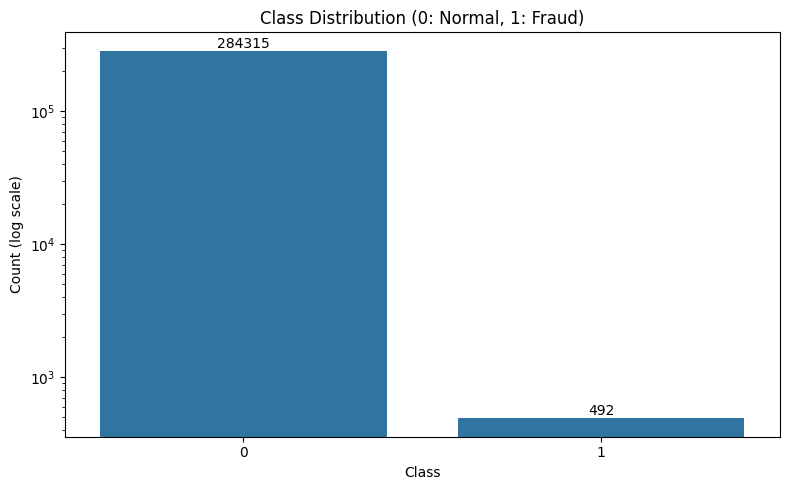

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x="Class", data=df)
plt.yscale("log")
plt.title("Class Distribution (0: Normal, 1: Fraud)")
plt.xlabel("Class")
plt.ylabel("Count (log scale)")

# Adiciona os valores absolutos acima de cada barra
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Por meio do é possível ver o grande desbalanceamento que existe entre as classes (284K vs 492)

# Tratamento da Base

Aplicando um processo de normalizaçao nas colunas 'Amount' e 'Time'

In [ ]:
scaler = StandardScaler()
df['scaled_Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

df = df.drop(['Time', 'Amount'], axis=1)

Para treinar o modelo usaremos apenas as transações legítimas, ocultando as fraudes do modelo

In [ ]:
normal_df = df[df['Class'] == 0]
fraud_df = df[df['Class'] == 1]

X_normal = normal_df.drop('Class', axis=1)
X_fraud = fraud_df.drop('Class', axis=1)

Dividindo em treino e teste a base, lembrando que usamos apenas as transações não fraudulentas para o treino

In [ ]:
X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)

#Iniciando a modelagem do VAE

Para resolver esse problema será utilizado um Autoencoder Variacional(VAE). O modelo foi montado baseado no código disponibilizado em https://keras.io/examples/generative/vae/ que é a página oficial do keras, a partir dele foram feitas adaptaçoes para esse dataset e para melhorar o modelo

Criando a camada latente do VAE

In [ ]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


Criando a parte do Encoder

In [ ]:
latent_dim = 16
n_features = 30

#ENCODER
encoder_inputs = keras.Input(shape=(n_features,))
x = layers.Dense(64, activation="relu")(encoder_inputs)
x = layers.Dense(32, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      1,984 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │        528 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │        528 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 16)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,120 (20.00 KB)

 Trainable params: 5,120 (20.00 KB)

 Non-trainable params: 0 (0.00 B)

Criando o decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32, activation="relu")(latent_inputs)
x = layers.Dense(64, activation="relu")(x)

decoder_outputs = layers.Dense(n_features)(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,606 (17.99 KB)

 Trainable params: 4,606 (17.99 KB)

 Non-trainable params: 0 (0.00 B)

Aqui personalizamos uma callback que irá aumentando progressivamente o peso da KL, para permitir que o modelo foque em aprender a reconstruir os dados nas épocas iniciais (quando o peso da KL é baixo) antes de aplicar a força total da regularização do espaço latente

In [ ]:
class KLAnnealingCallback(keras.callbacks.Callback):
    def __init__(self, kl_weight_max=1.0, epochs_for_annealing=10):
        super().__init__()
        self.kl_weight_max = kl_weight_max
        self.epochs_for_annealing = epochs_for_annealing

    def on_epoch_begin(self, epoch, logs=None):
        # Aumenta o peso linearmente de 0 até kl_weight_max
        new_kl_weight = min(self.kl_weight_max, epoch / self.epochs_for_annealing)
        # Atualiza o peso diretamente no modelo
        self.model.kl_weight.assign(new_kl_weight)
        print(f"Epoch {epoch+1}: Setting kl_weight to {self.model.kl_weight.numpy():.4f}")


Implementando agora o VAE completo, unindo todas as partes(encoder,camada latente,decoder) e definindo alguns metodos personalizados para o modelo, para deixar ele mais personalizado e permitindo o uso do KLanneling

In [ ]:
class VAE(keras.Model): #herdar keras.Model nos permite personalizar exatamente como o modelo é treinado e avaliado
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weight = tf.Variable(0.0, trainable=False, name='kl_weight')
        # Trackers para monitoramento detalhado
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        _, _, z = self.encoder(inputs)
        return self.decoder(z)

    #Personalizando o processo de treinamento do modelo
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction), axis=-1
                )
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + self.kl_weight * kl_loss

        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Atualizando as métricas
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    # Adicionando o test_step para que a validação funcione corretamente
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mean_squared_error(data, reconstruction), axis=-1
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + self.kl_weight * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
vae = VAE(encoder, decoder)
kl_annealing_callback = KLAnnealingCallback(kl_weight_max=0.5, epochs_for_annealing=15)


In [ ]:
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 16), (None,    │         5,120 │
│                                 │ 16), (None, 16))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 30)             │         4,606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,726 (37.99 KB)

 Trainable params: 9,726 (37.99 KB)

 Non-trainable params: 0 (0.00 B)

# Treinamento do VAE

In [ ]:
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(X_train,
                  epochs=30,
                  batch_size=128,
                  validation_data=(X_val,),
                  callbacks=[kl_annealing_callback])

Epoch 1: Setting kl_weight to 0.0000
Epoch 1/30
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - kl_loss: 159.0665 - reconstruction_loss: 84.6855 - total_loss: 84.6855 - val_kl_loss: 240.8975 - val_reconstruction_loss: 17.9266 - val_total_loss: 17.9266
Epoch 2: Setting kl_weight to 0.0667
Epoch 2/30
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - kl_loss: 91.4553 - reconstruction_loss: 16.7285 - total_loss: 22.8255 - val_kl_loss: 55.2761 - val_reconstruction_loss: 12.1744 - val_total_loss: 15.8595
Epoch 3: Setting kl_weight to 0.1333
Epoch 3/30
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - kl_loss: 45.5383 - reconstruction_loss: 11.7321 - total_loss: 17.8038 - val_kl_loss: 41.4478 - val_reconstruction_loss: 9.5715 - val_total_loss: 15.0979
Epoch 4: Setting kl_weight to 0.2000
Epoch 4/30
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kl_loss: 37.4030 - reconstruction_loss: 9.6582 - total_loss: 17.1388 - val_kl_loss: 36.1952 - val_reconstruction_loss: 8.0274 - val_total_loss: 15.2665
Epoch 5: Sett

Calculando o erro de reconstrução para o conjunto de validação

In [ ]:
reconstructions = vae.predict(X_val)
reconstruction_errors = tf.keras.losses.mse(reconstructions, X_val)

1777/1777 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step


Definindo o limiar de anomalia baseado no percentil 99 dos erros de reconstrução. Então qualquer transação com erro acima deste valor será considerada uma fraude

In [ ]:
threshold = np.percentile(reconstruction_errors, 99)
print(f"Limiar de anomalia definido: {threshold}")

Limiar de anomalia definido: 0.27134317198709557


Adicionado as transações fraudulentas para a fase de teste do modelo

In [ ]:
X_test = np.concatenate([X_val, X_fraud])
y_test = np.concatenate([np.zeros(len(X_val)), np.ones(len(X_fraud))])

Agora a etapa da avaliação final. É gerado previsões aplicando o limiar de anomalia nos erros de reconstrução do conjunto de teste.

In [ ]:
test_reconstructions = vae.predict(X_test)
test_errors = tf.keras.losses.mse(test_reconstructions, X_test)
y_pred = [1 if error > threshold else 0 for error in test_errors]

1793/1793 ━━━━━━━━━━━━━━━━━━━━ 2s 940us/step


Avaliando o resultado obtido por meio do relatório de classificação do Scikit-learn e da matriz de confusão

In [ ]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     56863
         1.0       0.41      0.81      0.54       492

    accuracy                           0.99     57355
   macro avg       0.70      0.90      0.77     57355
weighted avg       0.99      0.99      0.99     57355

[[56278   585]
 [   93   399]]


Vendo o trade-off entre precisão e o recall do modelo para cada limiar de erro possível.

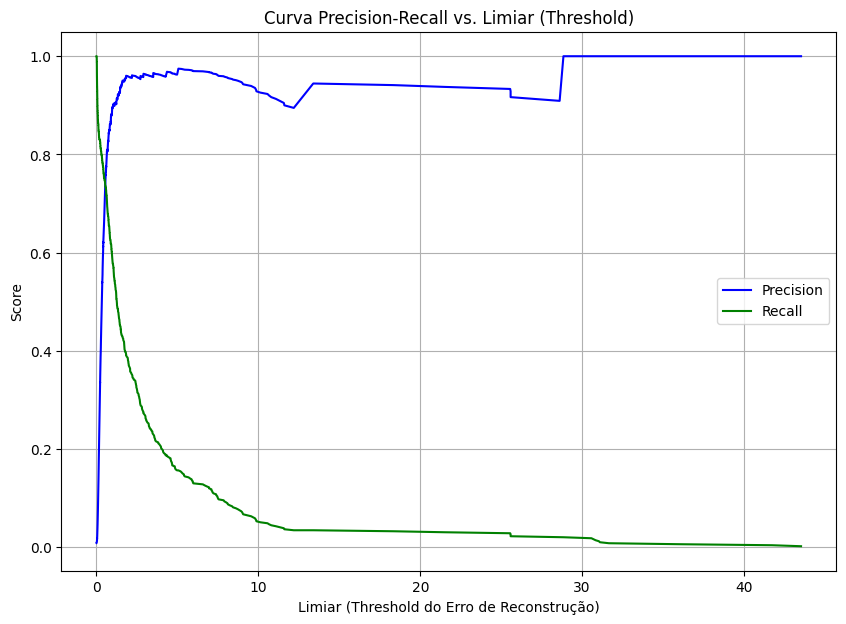

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, test_errors)

plt.figure(figsize=(10, 7))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="green")
plt.title('Curva Precision-Recall vs. Limiar (Threshold)')
plt.xlabel('Limiar (Threshold do Erro de Reconstrução)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.savefig('precision_recall_curve.png')
plt.show()


Personalizando agora o limiar manualmente visando obter melhores resultados

In [ ]:
novo_limiar = 1
y_pred_novo = [1 if error > novo_limiar else 0 for error in test_errors]

In [ ]:
print(classification_report(y_test, y_pred_novo))
print(confusion_matrix(y_test, y_pred_novo))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       0.90      0.58      0.71       492

    accuracy                           1.00     57355
   macro avg       0.95      0.79      0.85     57355
weighted avg       1.00      1.00      1.00     57355

[[56830    33]
 [  206   286]]


In [ ]:
novo_limiar2 = 0.8
y_pred_novo2 = [1 if error > novo_limiar2 else 0 for error in test_errors]

In [ ]:
print(classification_report(y_test, y_pred_novo2))
print(confusion_matrix(y_test, y_pred_novo2))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       0.85      0.65      0.73       492

    accuracy                           1.00     57355
   macro avg       0.92      0.82      0.87     57355
weighted avg       1.00      1.00      1.00     57355

[[56806    57]
 [  174   318]]


Com isso foi obtido um f1-score geral melhor(macro avg) para o modelo. Assim finalizamos os testes do modelo, chegando a um resultado consideravelmente bom baseado no problema enfrentado, com um f1-score de 87%, simbolizando um bom equilíbrio entre precision e o recall,isso demonstra que o modelo é simultaneamente eficaz e confiável

# Visualizando o PCA

Primeiro fazemos um undersampling da classe de transações normais para poder se tornar mais fácil visivelmente essa avaliação

In [ ]:
# Pegar 3x mais amostras normais que fraudulentas
n_samples = len(fraud_df) * 3

X_viz_normal = normal_df.sample(n=n_samples, random_state=42).drop('Class', axis=1)
X_viz_fraud = fraud_df.drop('Class', axis=1)

X_viz = pd.concat([X_viz_normal, X_viz_fraud])
y_viz = np.concatenate([np.zeros(len(X_viz_normal)), np.ones(len(X_viz_fraud))])

Obtendo a representação do espaço latente

In [ ]:
z_mean_viz, _, _ = vae.encoder.predict(X_viz)

print(f"Dimensão do espaço latente original: {z_mean_viz.shape[1]}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Dimensão do espaço latente original: 16


Aplicando o PCA na camada latente

In [ ]:
pca = PCA(n_components=2)
z_mean_2d = pca.fit_transform(z_mean_viz)

print("Dimensão após PCA: ", z_mean_2d.shape[1])

explained_variance = pca.explained_variance_ratio_
print(f"Variância explicada pelo 1º componente: {explained_variance[0]:.2%}")
print(f"Variância explicada pelo 2º componente: {explained_variance[1]:.2%}")
print(f"Variância total explicada pelos 2 componentes: {np.sum(explained_variance):.2%}")


Dimensão após PCA:  2
Variância explicada pelo 1º componente: 51.27%
Variância explicada pelo 2º componente: 11.71%
Variância total explicada pelos 2 componentes: 62.98%


Visualizando o resultado obtido graficamente

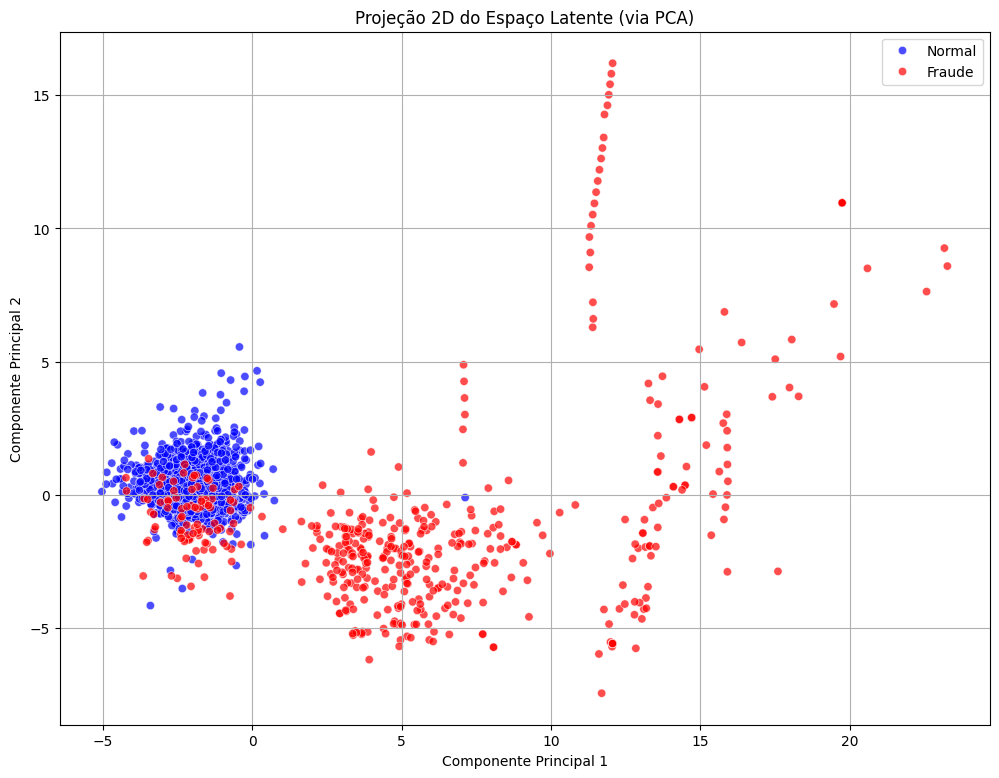

In [ ]:
df_plot = pd.DataFrame(z_mean_2d, columns=['Componente_1', 'Componente_2'])
df_plot['Classe'] = y_viz
df_plot['Classe'] = df_plot['Classe'].map({0: 'Normal', 1: 'Fraude'})

plt.figure(figsize=(12, 9))
sns.scatterplot(
    x='Componente_1',
    y='Componente_2',
    hue='Classe',
    data=df_plot,
    palette={'Normal': 'blue', 'Fraude': 'red'},
    alpha=0.7
)
plt.title('Projeção 2D do Espaço Latente (via PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.savefig('pca_plot.png')
plt.show()

O gráfico da projeção PCA mostra claramente a formação de um cluster denso para as transações normais e agrupamentos distintos para as transações de fraude. Existe uma separação visual clara entre a maioria dos pontos da classe "Normal" e da classe "Fraude". Isso indica que o VAE aprendeu uma representação interna que diferencia as duas classes, mesmo tendo sido treinado apenas com dados normais.